In [240]:
from sklearn.preprocessing import LabelEncoder
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 100)

In [188]:
# URL'den HTML içeriğini alıp parse eden fonksiyon
def getAndParseURL(url):
    result = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = bs(result.text, 'html.parser')
    return soup

In [189]:
# Belirli bir sayfa aralığı için sayfa URL'leri oluşturur
def sayfa_numarasi_bul(base_url, sayfa_sayisi):
    sayfa_numarasi = [f"{base_url}?page={i}" for i in range(1, sayfa_sayisi + 1)]
    return sayfa_numarasi

In [190]:
# Her bir sayfadaki ilanların URL'lerini toplar
def ilanlar(sayfa_url_listesi):
    tum_ilanlar = []
    for sayfa_url in sayfa_url_listesi:
        html = getAndParseURL(sayfa_url)
        for sonuc in html.findAll("a", {"class": "zl-card-inner"}):
            tum_ilanlar.append("https://www.zingat.com" + sonuc.get("href"))
    return tum_ilanlar

In [191]:
# Ana URL
base_url = "https://www.zingat.com/istanbul-satilik-konut"

In [192]:
# 50 sayfa için
sayfa_sayisi = 50

In [193]:
# Sayfa URL'lerini al
sayfa_numaralari = sayfa_numarasi_bul(base_url, sayfa_sayisi)

In [194]:
# Tüm ilan URL'lerini al
tum_ilan_url_listesi = ilanlar(sayfa_numaralari)

In [195]:
# Sonuçları gösterme
for url in tum_ilan_url_listesi:
    print(url)

https://www.zingat.com/sisli-merkezde-muhtesem-konum-genis-3-1-daire-can-girgin-4961891i
https://www.zingat.com/sisli-mecidiyekoy-yatirimlik-2-1-firsat-daire-can-girgin-4922842i
https://www.zingat.com/goztepe-park-ve-deniz-manzarali-guvenlikli-residence-4-1-4975569i
https://www.zingat.com/ortakoyde-kose-konumda-giris-dubleks-satilik-4-2-daire-5004610i
https://www.zingat.com/sinpas-lagun-2-el-tek-yetkili-ofisten-esyali-4-1-lilyum-teras-5007793i
https://www.zingat.com/cekmekoy-eksioglunda-doga-evimden-kapali-otoparkli-luks-4-1-5007558i
https://www.zingat.com/bahcelievler-cumh-mah-11-yillik-bina-dubleks-3-2-150-m2-satilik-4984370i
https://www.zingat.com/sinpas-lagun-2-el-tek-yetkili-ofisten-bos-4-1-lilyum-bahce-5007927i
https://www.zingat.com/beykoz-yalikoy-mh-azadeler-sok-mustakil-iki-katli-satilik-ev-5007791i
https://www.zingat.com/ozlem-sitesi-feraf-sahane-ortam-icinde-satilik-3-1-daire-5007796i
https://www.zingat.com/beylikduzu-gezgen-insaattan-acil-satilik-2-1-daire-firsati-4956812i


In [196]:
# Bir ilandan detayları çek
def scrape_listing_details(listing_url):
    details_soup = getAndParseURL(listing_url)
    if details_soup:
        details = {}
        try:
            # Özelliklerin bulunduğu listeyi al
            property_list = details_soup.find_all('li', {'class': 'col-md-6'})
            for property_item in property_list:
                # Özellik adını ve değerini al
                property_name = property_item.find('strong').text.strip()
                property_value = property_item.find('span').text.strip()
                details[property_name] = property_value
                
            # Fiyat bilgisini al
            price_info = details_soup.find('strong', {'itemprop': 'price'})
            if price_info:
                details['Price'] = price_info.text.strip()
            else:
                details['Price'] = 'Fiyat Bilgisi Bulunamadı'
                
                
        except AttributeError as e:
            print(f"Couldn't scrape some of the details for {listing_url}: {e}")
        return details
    return {}

In [197]:
# Tüm ilan detaylarını çekme ve DataFrame oluşturma
listings_details = [scrape_listing_details(url) for url in tum_ilan_url_listesi]

In [198]:
# DataFrame oluşturma ve CSV'ye kaydetme
df = pd.DataFrame(listings_details)

In [199]:
df.to_csv("zingat_istanbul_verileri.csv",index=False)

# --------------------------------------------------------------------

In [200]:
df = pd.read_csv("zingat_istanbul_verileri.csv")

In [201]:
df.sample(5)

,İlan Tarihi,İlan no,Net m²,Brüt m²,Oda Sayısı,Banyo Sayısı,Binadaki Kat Sayısı,Isıtma Tipi,Konut Şekli,Bulunduğu Kat,Görüntülü Ev Gezintisi\n?,Bina Yaşı,Hayvan Dostu Patili Evler,Mobilya Durumu,Kullanım Durumu,Yapının Durumu,Aidat,Kira Getirisi,Kimden,Tapu Durumu,Krediye Uygun,Price,Takasa Uygun,Dış Cephe,Yapı Tipi,Arsa Alanı,Zemin Etüdlü,Tarihi Eser,Ada,Parsel,Kapalı Alan
408,18 Ocak 2024,4960103,45,75m²,1+1,1,8,Merkezi Sistem,NaN,5,NaN,0,NaN,NaN,Boş,Yapım Aşamasında,0 TL (aylık),0 TL (aylık),NaN,NaN,Evet,2.633.964 TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,17 Ocak 2024,5007805,86,112m²,3+1,1,8,Merkezi Sistem (Isı Payı Ölçer),Ara Kat,6,?,0,Evet,Eşyasız,Boş,Sıfır,0 TL (aylık),25.000 TL (aylık),Danışman,Kat İrtifakı,Evet,5.598.000 TL,Evet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,17 Ocak 2024,5007729,61,93m²,2+1,2,10-20 arası,NaN,Ara Kat,8,NaN,1,NaN,Eşyasız,Boş,NaN,0 TL (aylık),0 TL (aylık),NaN,NaN,Evet,9.600.000 TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,17 Ocak 2024,4986103,90,110m²,2+1,2,10-20 arası,Merkezi Sistem (Isı Payı Ölçer),Ara Kat,8,?,2,Evet,Sadece Mutfak,Boş,Sıfır,200 TL (aylık),17.000 TL (aylık),Danışman,Kat Mülkiyeti,Evet,3.250.000 TL,Evet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,17 Ocak 2024,4986095,47,55m²,1+1,1,10-20 arası,Merkezi Sistem (Isı Payı Ölçer),Ara Kat,9,?,2,Evet,Sadece Mutfak,Kiracılı,İkinci El,600 TL (aylık),20.000 TL (aylık),Danışman,Kat İrtifakı,Evet,3.775.000 TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
df.shape

(1050, 31)

In [203]:
df.columns

Index(['İlan Tarihi', 'İlan no', 'Net m²', 'Brüt m²', 'Oda Sayısı',
       'Banyo Sayısı', 'Binadaki Kat Sayısı', 'Isıtma Tipi', 'Konut Şekli',
       'Bulunduğu Kat', 'Görüntülü Ev Gezintisi\n?', 'Bina Yaşı',
       'Hayvan Dostu Patili Evler', 'Mobilya Durumu', 'Kullanım Durumu',
       'Yapının Durumu', 'Aidat', 'Kira Getirisi', 'Kimden', 'Tapu Durumu',
       'Krediye Uygun', 'Price', 'Takasa Uygun', 'Dış Cephe', 'Yapı Tipi',
       'Arsa Alanı', 'Zemin Etüdlü', 'Tarihi Eser', 'Ada', 'Parsel',
       'Kapalı Alan'],
      dtype='object')

In [204]:
df = df.drop(columns=["İlan Tarihi","İlan no","Görüntülü Ev Gezintisi\n?","Hayvan Dostu Patili Evler","Kira Getirisi","Yapı Tipi","Ada","Parsel",
                      'Takasa Uygun', 'Dış Cephe', 'Yapı Tipi', 'Arsa Alanı','Zemin Etüdlü',
                      'Tarihi Eser', 'Ada', 'Parsel', 'Kapalı Alan',"Tapu Durumu","Kimden","Yapının Durumu","Aidat"])

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Net m²               1050 non-null   object
 1   Brüt m²              1050 non-null   object
 2   Oda Sayısı           1024 non-null   object
 3   Banyo Sayısı         1024 non-null   object
 4   Binadaki Kat Sayısı  1032 non-null   object
 5   Isıtma Tipi          871 non-null    object
 6   Konut Şekli          782 non-null    object
 7   Bulunduğu Kat        971 non-null    object
 8   Bina Yaşı            1018 non-null   object
 9   Mobilya Durumu       878 non-null    object
 10  Kullanım Durumu      987 non-null    object
 11  Krediye Uygun        1050 non-null   object
 12  Price                1050 non-null   object
dtypes: object(13)
memory usage: 106.8+ KB


In [206]:
df.isna().sum()

Net m²                   0
Brüt m²                  0
Oda Sayısı              26
Banyo Sayısı            26
Binadaki Kat Sayısı     18
Isıtma Tipi            179
Konut Şekli            268
Bulunduğu Kat           79
Bina Yaşı               32
Mobilya Durumu         172
Kullanım Durumu         63
Krediye Uygun            0
Price                    0
dtype: int64

In [207]:
df.head()

,Net m²,Brüt m²,Oda Sayısı,Banyo Sayısı,Binadaki Kat Sayısı,Isıtma Tipi,Konut Şekli,Bulunduğu Kat,Bina Yaşı,Mobilya Durumu,Kullanım Durumu,Krediye Uygun,Price
0,150,175m²,3+1,1,3,Kombi (Doğalgaz),Ara Kat,1,40 ve üzeri,Eşyasız,Mülk Sahibi,Evet,8.950.000 TL
1,80,95m²,2+1,1,7,Kombi (Doğalgaz),Ara Kat,6,21-25 arası,Eşyasız,Boş,Hayır,1.750.000 TL
2,230,300m²,4+1,2,10-20 arası,Fancoil,NaN,6,16-20 arası,NaN,Mülk Sahibi,Evet,40.000.000 TL
3,140,160m²,4+2,2,5,Kombi (Doğalgaz),Ters Dubleks,Giriş Katı,11-15 arası,Eşyasız,Mülk Sahibi,Evet,13.500.000 TL
4,185,209m²,4+1,2,2,Klima,NaN,2,11-15 arası,Eşyalı (Mobilyalı),Kiracılı,Evet,15.200.000 TL


### Boş verileri doldurma

In [208]:
df.fillna(df.mode().iloc[0], inplace=True)

In [209]:
df.isna().sum()

Net m²                 0
Brüt m²                0
Oda Sayısı             0
Banyo Sayısı           0
Binadaki Kat Sayısı    0
Isıtma Tipi            0
Konut Şekli            0
Bulunduğu Kat          0
Bina Yaşı              0
Mobilya Durumu         0
Kullanım Durumu        0
Krediye Uygun          0
Price                  0
dtype: int64

 # VERİLERİ HAZIRLAMA

In [210]:
# Oda sayısı ile salon sayısını ayırıyoruz
df[['Oda Sayısı', 'Salon Sayısı']] = df['Oda Sayısı'].str.split('+', expand=True)

In [211]:
df['Net m²'] = df['Net m²'].str.replace('-', '')
df['Brüt m²'] = df['Brüt m²'].str.replace('m²', '')

In [212]:
df['Binadaki Kat Sayısı'] = df['Binadaki Kat Sayısı'].map({'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'10': 10,
                                                           '10-20 arası': 15,  # Ortalama bir değer
                                                           '20 ve üzeri': 25 # Ortalama bir değer
                                                          })

In [213]:
df['Oda Sayısı'] = df['Oda Sayısı'].map({'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'10 ve üzeri': 10})

In [214]:
df['Banyo Sayısı'] = df['Banyo Sayısı'].replace('6 ve üzeri', 6)

In [215]:
df['Salon Sayısı'] = df['Salon Sayısı'].replace('0 (Stüdyo)', 0)

In [216]:
df['Price'] = df['Price'].str.replace('TL', '').str.replace(' ', '').apply(lambda x: float(x.replace('.', '').replace(',', '.')))

In [217]:
df

,Net m²,Brüt m²,Oda Sayısı,Banyo Sayısı,Binadaki Kat Sayısı,Isıtma Tipi,Konut Şekli,Bulunduğu Kat,Bina Yaşı,Mobilya Durumu,Kullanım Durumu,Krediye Uygun,Price,Salon Sayısı
0,150,175,3,1,3,Kombi (Doğalgaz),Ara Kat,1,40 ve üzeri,Eşyasız,Mülk Sahibi,Evet,8950000.0,1
1,80,95,2,1,7,Kombi (Doğalgaz),Ara Kat,6,21-25 arası,Eşyasız,Boş,Hayır,1750000.0,1
2,230,300,4,2,15,Fancoil,Ara Kat,6,16-20 arası,Eşyasız,Mülk Sahibi,Evet,40000000.0,1
3,140,160,4,2,5,Kombi (Doğalgaz),Ters Dubleks,Giriş Katı,11-15 arası,Eşyasız,Mülk Sahibi,Evet,13500000.0,2
4,185,209,4,2,2,Klima,Ara Kat,2,11-15 arası,Eşyalı (Mobilyalı),Kiracılı,Evet,15200000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,360,420,5,3,4,Kombi (Doğalgaz),Çatı Dubleksi,4,21-25 arası,Eşyasız,Mülk Sahibi,Evet,38000000.0,2
1046,70,75,2,1,5,Kombi (Doğalgaz),Giriş Kat,Giriş Katı,0,Eşyasız,Boş,Evet,3150000.0,1
1047,27,30,2,1,5,Kombi (Doğalgaz),Ara Kat,1,0,Eşyasız,Boş,Hayır,475000.0,1
1048,135,150,3,2,7,Kombi (Doğalgaz),Çatı Dubleksi,Çatı Katı,0,Eşyasız,Boş,Evet,21000000.0,2


In [218]:
df

,Net m²,Brüt m²,Oda Sayısı,Banyo Sayısı,Binadaki Kat Sayısı,Isıtma Tipi,Konut Şekli,Bulunduğu Kat,Bina Yaşı,Mobilya Durumu,Kullanım Durumu,Krediye Uygun,Price,Salon Sayısı
0,150,175,3,1,3,Kombi (Doğalgaz),Ara Kat,1,40 ve üzeri,Eşyasız,Mülk Sahibi,Evet,8950000.0,1
1,80,95,2,1,7,Kombi (Doğalgaz),Ara Kat,6,21-25 arası,Eşyasız,Boş,Hayır,1750000.0,1
2,230,300,4,2,15,Fancoil,Ara Kat,6,16-20 arası,Eşyasız,Mülk Sahibi,Evet,40000000.0,1
3,140,160,4,2,5,Kombi (Doğalgaz),Ters Dubleks,Giriş Katı,11-15 arası,Eşyasız,Mülk Sahibi,Evet,13500000.0,2
4,185,209,4,2,2,Klima,Ara Kat,2,11-15 arası,Eşyalı (Mobilyalı),Kiracılı,Evet,15200000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,360,420,5,3,4,Kombi (Doğalgaz),Çatı Dubleksi,4,21-25 arası,Eşyasız,Mülk Sahibi,Evet,38000000.0,2
1046,70,75,2,1,5,Kombi (Doğalgaz),Giriş Kat,Giriş Katı,0,Eşyasız,Boş,Evet,3150000.0,1
1047,27,30,2,1,5,Kombi (Doğalgaz),Ara Kat,1,0,Eşyasız,Boş,Hayır,475000.0,1
1048,135,150,3,2,7,Kombi (Doğalgaz),Çatı Dubleksi,Çatı Katı,0,Eşyasız,Boş,Evet,21000000.0,2


In [219]:
df['Net m²'] = pd.to_numeric(df['Net m²']).astype('Int64')
df['Brüt m²'] = pd.to_numeric(df['Brüt m²']).astype('Int64')
df['Banyo Sayısı'] = pd.to_numeric(df['Banyo Sayısı']).astype('Int64')
df['Oda Sayısı'] = pd.to_numeric(df['Oda Sayısı']).astype('Int64')
df['Salon Sayısı'] = pd.to_numeric(df['Salon Sayısı']).astype('Int64')
#df['Binadaki Kat Sayısı'] = pd.to_numeric(df['Binadaki Kat Sayısı']).astype('Int64')
df["Price"] = pd.to_numeric(df['Price']).astype('Int64')

In [220]:
dummy_columns = ["Binadaki Kat Sayısı", "Krediye Uygun", "Konut Şekli", "Isıtma Tipi",
                 "Bulunduğu Kat", "Bina Yaşı", "Mobilya Durumu", "Kullanım Durumu"]

df = pd.get_dummies(df, columns=dummy_columns, drop_first=True)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 97 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   Net m²                                       1047 non-null   Int64
 1   Brüt m²                                      1050 non-null   Int64
 2   Oda Sayısı                                   1050 non-null   Int64
 3   Banyo Sayısı                                 1050 non-null   Int64
 4   Price                                        1050 non-null   Int64
 5   Salon Sayısı                                 1047 non-null   Int64
 6   Binadaki Kat Sayısı_2                        1050 non-null   uint8
 7   Binadaki Kat Sayısı_3                        1050 non-null   uint8
 8   Binadaki Kat Sayısı_4                        1050 non-null   uint8
 9   Binadaki Kat Sayısı_5                        1050 non-null   uint8
 10  Binadaki Kat Sayısı_6   

In [222]:
# Sütun adlarının benzersiz olup olmadığını kontrol etme
duplicate_columns = df.columns[df.columns.duplicated()]
print("Benzersiz olmayan sütun adları:", duplicate_columns)

Benzersiz olmayan sütun adları: Index([], dtype='object')


In [223]:
df["Oda Sayısı"].value_counts()

2     413
3     321
4     122
1     104
5      51
6      17
7      12
8       7
10      3
Name: Oda Sayısı, dtype: Int64

In [224]:
df.isna().sum().sort_values(ascending=False)

Net m²                            3
Salon Sayısı                      3
Bulunduğu Kat_9                   0
Bulunduğu Kat_Müstakil            0
Bulunduğu Kat_Kot 4               0
                                 ..
Konut Şekli_Tripleks              0
Konut Şekli_Ters Dubleks          0
Konut Şekli_Teras Katı            0
Konut Şekli_Intermediate Floor    0
Kullanım Durumu_Vacant            0
Length: 97, dtype: int64

In [225]:
df['Net m²'].fillna(df['Net m²'].mode()[0], inplace=True)
df['Salon Sayısı'].fillna(df['Salon Sayısı'].mode()[0], inplace=True)

In [226]:
df.columns

Index(['Net m²', 'Brüt m²', 'Oda Sayısı', 'Banyo Sayısı', 'Price',
       'Salon Sayısı', 'Binadaki Kat Sayısı_2', 'Binadaki Kat Sayısı_3',
       'Binadaki Kat Sayısı_4', 'Binadaki Kat Sayısı_5',
       'Binadaki Kat Sayısı_6', 'Binadaki Kat Sayısı_7',
       'Binadaki Kat Sayısı_8', 'Binadaki Kat Sayısı_9',
       'Binadaki Kat Sayısı_10', 'Binadaki Kat Sayısı_15',
       'Binadaki Kat Sayısı_25', 'Krediye Uygun_Hayır', 'Krediye Uygun_Yes',
       'Konut Şekli_Ara Kat', 'Konut Şekli_Bahçe Dubleksi',
       'Konut Şekli_Bahçe Katı', 'Konut Şekli_Dubleks', 'Konut Şekli_Duplex',
       'Konut Şekli_En Üst Kat', 'Konut Şekli_Fourlex',
       'Konut Şekli_Giriş Kat', 'Konut Şekli_Intermediate Floor',
       'Konut Şekli_Teras Katı', 'Konut Şekli_Ters Dubleks',
       'Konut Şekli_Tripleks', 'Konut Şekli_Çatı Dubleksi',
       'Isıtma Tipi_Combi Boiler (Natural Gas)', 'Isıtma Tipi_Fancoil',
       'Isıtma Tipi_Kalorifer (Doğalgaz)', 'Isıtma Tipi_Klima',
       'Isıtma Tipi_Kombi (Doğalgaz)

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 97 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   Net m²                                       1050 non-null   Int64
 1   Brüt m²                                      1050 non-null   Int64
 2   Oda Sayısı                                   1050 non-null   Int64
 3   Banyo Sayısı                                 1050 non-null   Int64
 4   Price                                        1050 non-null   Int64
 5   Salon Sayısı                                 1050 non-null   Int64
 6   Binadaki Kat Sayısı_2                        1050 non-null   uint8
 7   Binadaki Kat Sayısı_3                        1050 non-null   uint8
 8   Binadaki Kat Sayısı_4                        1050 non-null   uint8
 9   Binadaki Kat Sayısı_5                        1050 non-null   uint8
 10  Binadaki Kat Sayısı_6   

In [228]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X=df.drop("Price",axis=1)
y=df["Price"]

# Verileri eğitim ve test alt kümelerine bölmek
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
from pycaret.regression import *

In [230]:
setup(df, target="Price")

,Description,Value
0,Session id,6994
1,Target,Price
2,Target type,Regression
3,Original data shape,"(1050, 97)"
4,Transformed data shape,"(1050, 97)"
5,Transformed train set shape,"(735, 97)"
6,Transformed test set shape,"(315, 97)"
7,Numeric features,96
8,Preprocess,True
9,Imputation type,simple


In [231]:
best_model=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,8685310.8073,1258126387626368.0000,29157852.5538,0.3426,0.7364,1.6600,0.1420
rf,Random Forest Regressor,8553000.1403,1276266667481633.0000,28955486.0747,0.2861,0.6935,1.4042,0.1350
huber,Huber Regressor,9349129.3974,1816920808444099.5000,34252127.0846,0.2638,0.9355,1.0677,0.0270
par,Passive Aggressive Regressor,10113605.7407,1968597117725092.7500,35740862.8505,0.1910,0.8695,1.0699,0.0120
gbr,Gradient Boosting Regressor,9034428.2394,1470689110692438.5000,30197645.5046,0.1427,0.7457,1.6833,0.0460
ada,AdaBoost Regressor,17043326.9609,1523509247341016.5000,33630302.4000,0.0971,1.4264,4.0232,0.0330
lightgbm,Light Gradient Boosting Machine,10474937.9118,1339684522317536.2500,31920369.0985,0.0732,1.0009,1.6719,0.1030
dummy,Dummy Regressor,15918083.2963,2263703726731543.0000,39345086.2518,-0.0323,1.4977,3.7251,0.0120
br,Bayesian Ridge,13116239.4637,2277979879449275.0000,39242466.5828,-0.7659,1.1229,2.2194,0.0130
dt,Decision Tree Regressor,10736950.6497,2245555133462231.7500,35851826.2846,-0.9759,0.8659,1.6298,0.0120


# Derin Öğrenme

In [233]:
# Veri setini normalize etme
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [234]:
# Veri türlerini kontrol etme ve dönüştürme
X_train_scaled = X_train_scaled.astype('float32')
y_train = y_train.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_test = y_test.astype('float32')

# NaN veya sonsuz değerleri kontrol etme
if np.any(np.isnan(X_train_scaled)) or np.any(np.isnan(y_train)):
    print("Eğitim verisinde NaN değerler var.")
if np.any(np.isnan(X_test_scaled)) or np.any(np.isnan(y_test)):
    print("Test verisinde NaN değerler var.")

In [235]:
# R² metriğini hesaplamak için özel bir fonksiyon
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [236]:
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Çıkış katmanı
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='huber_loss', metrics=[r_squared])

In [238]:
# Modeli eğitme
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=150, batch_size=16)

Epoch 1/150
53/53 [==============================] - 2s 7ms/step - loss: 14397745.0000 - r_squared: -0.7882 - val_loss: 10706940.0000 - val_r_squared: -0.7205
Epoch 2/150
53/53 [==============================] - 0s 3ms/step - loss: 14382599.0000 - r_squared: -0.5791 - val_loss: 10635353.0000 - val_r_squared: -0.7089
Epoch 3/150
53/53 [==============================] - 0s 4ms/step - loss: 13811038.0000 - r_squared: -0.6280 - val_loss: 8887412.0000 - val_r_squared: -0.4503
Epoch 4/150
53/53 [==============================] - 0s 4ms/step - loss: 11990151.0000 - r_squared: -0.2191 - val_loss: 8157927.5000 - val_r_squared: -0.2010
Epoch 5/150
53/53 [==============================] - 0s 3ms/step - loss: 11756564.0000 - r_squared: -0.1414 - val_loss: 8032626.5000 - val_r_squared: -0.1804
Epoch 6/150
53/53 [==============================] - 0s 3ms/step - loss: 11644031.0000 - r_squared: -0.1164 - val_loss: 7927265.0000 - val_r_squared: -0.1548
Epoch 7/150
53/53 [==============================]

53/53 [==============================] - 0s 3ms/step - loss: 7884961.0000 - r_squared: 0.3549 - val_loss: 5633488.0000 - val_r_squared: 0.2923
Epoch 54/150
53/53 [==============================] - 0s 3ms/step - loss: 7936423.0000 - r_squared: 0.3933 - val_loss: 5588296.0000 - val_r_squared: 0.3180
Epoch 55/150
53/53 [==============================] - 0s 3ms/step - loss: 7820966.5000 - r_squared: 0.1537 - val_loss: 5591980.5000 - val_r_squared: 0.3048
Epoch 56/150
53/53 [==============================] - 0s 4ms/step - loss: 8002767.0000 - r_squared: 0.4164 - val_loss: 5597276.5000 - val_r_squared: 0.3043
Epoch 57/150
53/53 [==============================] - 0s 3ms/step - loss: 7877256.0000 - r_squared: 0.4647 - val_loss: 5632800.5000 - val_r_squared: 0.2989
Epoch 58/150
53/53 [==============================] - 0s 3ms/step - loss: 7825818.0000 - r_squared: 0.3022 - val_loss: 5607186.5000 - val_r_squared: 0.3043
Epoch 59/150
53/53 [==============================] - 0s 3ms/step - loss: 776

53/53 [==============================] - 0s 3ms/step - loss: 7053203.5000 - r_squared: 0.5629 - val_loss: 5458679.5000 - val_r_squared: 0.2888
Epoch 106/150
53/53 [==============================] - 0s 3ms/step - loss: 7188575.5000 - r_squared: -0.4323 - val_loss: 5450570.0000 - val_r_squared: 0.2862
Epoch 107/150
53/53 [==============================] - 0s 3ms/step - loss: 7152664.0000 - r_squared: 0.4728 - val_loss: 5447694.5000 - val_r_squared: 0.2844
Epoch 108/150
53/53 [==============================] - 0s 3ms/step - loss: 7093662.5000 - r_squared: 0.4442 - val_loss: 5493208.5000 - val_r_squared: 0.2583
Epoch 109/150
53/53 [==============================] - 0s 3ms/step - loss: 7062504.0000 - r_squared: 0.4744 - val_loss: 5469710.5000 - val_r_squared: 0.2736
Epoch 110/150
53/53 [==============================] - 0s 3ms/step - loss: 6980271.0000 - r_squared: 0.5181 - val_loss: 5446754.0000 - val_r_squared: 0.2894
Epoch 111/150
53/53 [==============================] - 0s 3ms/step - lo

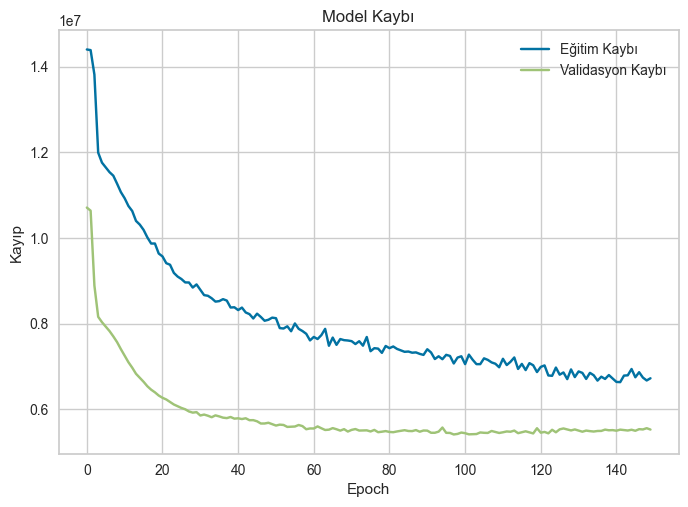

In [239]:
# Modelin eğitim ve validasyon kayıplarını görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Validasyon Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend()
plt.show()